In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
import cv2 
import seaborn as sns
import random
import pickle



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [ ]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
#print(tf.test.is_gpu_available())


In [2]:
train_data = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = .1,
    horizontal_flip = True
)
test_data = ImageDataGenerator(rescale = 1./255)

In [3]:
X_train_gen = train_data.flow_from_directory(
    "/kaggle/input/fer2013/train/train",
    target_size = (75, 75),
    batch_size = 64,
    class_mode = "categorical"
)
X_val = test_data.flow_from_directory(
    "/kaggle/input/fer2013/test/test",
    target_size = (75, 75),
    batch_size = 64,
    class_mode = "categorical"
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint

class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(X_train_gen.classes),
    y = X_train_gen.classes) 

num_classes = 7
keys = range(num_classes)
values = class_weights.copy()
class_weights = dict(zip(keys, values))
print(class_weights)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [5]:
#VGG19 base_model
base_model = InceptionV3(
    include_top = False,
    weights = None,
    input_shape = (75, 75, 3))

In [6]:
from tensorflow.keras.models import load_model
base_model.load_weights("/kaggle/input/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [7]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units = 64, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(units = 7, activation = "softmax"))

In [8]:
optimizer_1 = SGD(learning_rate = 0.01)
model.compile(optimizer = optimizer_1, loss = "categorical_crossentropy", metrics = ["acc"])

In [9]:
history = model.fit_generator(
    X_train_gen,
    epochs = 70,
    verbose = 1,
    class_weight = class_weights,
    validation_data = X_val
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/70
449/449 [==============================] - 305s 622ms/step - loss: 1.9042 - acc: 0.1781 - val_loss: 1.8878 - val_acc: 0.1952
Epoch 2/70
449/449 [==============================] - 94s 208ms/step - loss: 1.7224 - acc: 0.2845 - val_loss: 1.5663 - val_acc: 0.3944
Epoch 3/70
449/449 [==============================] - 93s 208ms/step - loss: 1.5707 - acc: 0.3664 - val_loss: 1.6433 - val_acc: 0.4178
Epoch 4/70
449/449 [==============================] - 95s 210ms/step - loss: 1.4611 - acc: 0.4219 - val_loss: 1.3988 - val_acc: 0.4746
Epoch 5/70
449/449 [==============================] - 94s 210ms/step - loss: 1.3799 - acc: 0.4625 - val_loss: 1.3063 - val_acc: 0.5025
Epoch 6/70
449/449 [==============================] - 93s 207ms/step - loss: 1.3147 - acc: 0.4870 - val_loss: 1.2888 - val_acc: 0.5135
Epoch 7/70
449/449 [==============================] - 91s 203ms/step - loss: 1.2597 - acc: 0.5060 - val_loss: 1.3172 - val_acc: 0.5064
Epoch 8/70
449/449 [==============================] - 

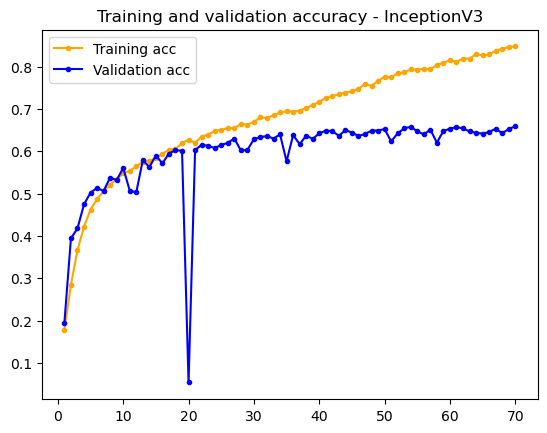

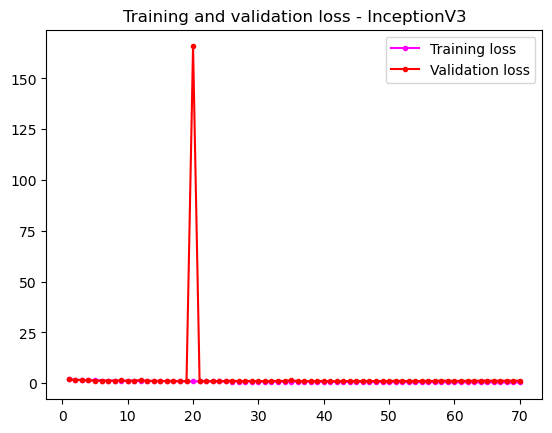

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.title('Training and validation accuracy - InceptionV3')
plt.plot(epochs, acc, 'orange', marker = '.', label = 'Training acc')
plt.plot(epochs, val_acc, 'blue', marker = '.', label = 'Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss - InceptionV3')
plt.plot(epochs, loss, 'magenta', marker = '.', label = 'Training loss')
plt.plot(epochs, val_loss, 'red', marker = '.', label = 'Validation loss')
plt.legend()
plt.show()

In [13]:
from tensorflow import keras 
model.save("/kaggle/working/Inveptionv3fer2013")

In [15]:
model_I = keras.models.load_model("/kaggle/working/Inveptionv3fer2013")

In [29]:
#create test data 
test_data = []
test_data_dir = "/kaggle/input/fer2013plus/test"
categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
def create_test_data():
    for cat in categories:
        path = os.path.join(test_data_dir, cat)
        class_num = categories.index(cat)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (75, 75))
            test_data.append([new_array, class_num])

In [30]:
create_test_data()

In [31]:
random.shuffle(test_data)
X_test = []
y_test = []
for features, labels in test_data:
    X_test.append(features)
    y_test.append(labels)
X_test = np.array(X_test).reshape(7048, 75, 75, 3)
y_test = np.array(y_test)

In [32]:
#image = cv2.imread("")
#print(len(test_data))
data_path = "/kaggle/working/"
pickle_out = open(data_path + "/X_test_rgb.pickle", "wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

In [33]:
pickle_out = open(data_path + "/y_test_rgb.pickle", "wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [45]:
print(X_test.shape)
#index_list = [0, 1, 2, 3, 4, 5, 6]
X_test = X_test/255.0

(7048, 75, 75, 3)


221/221 [==============================] - 5s 19ms/step


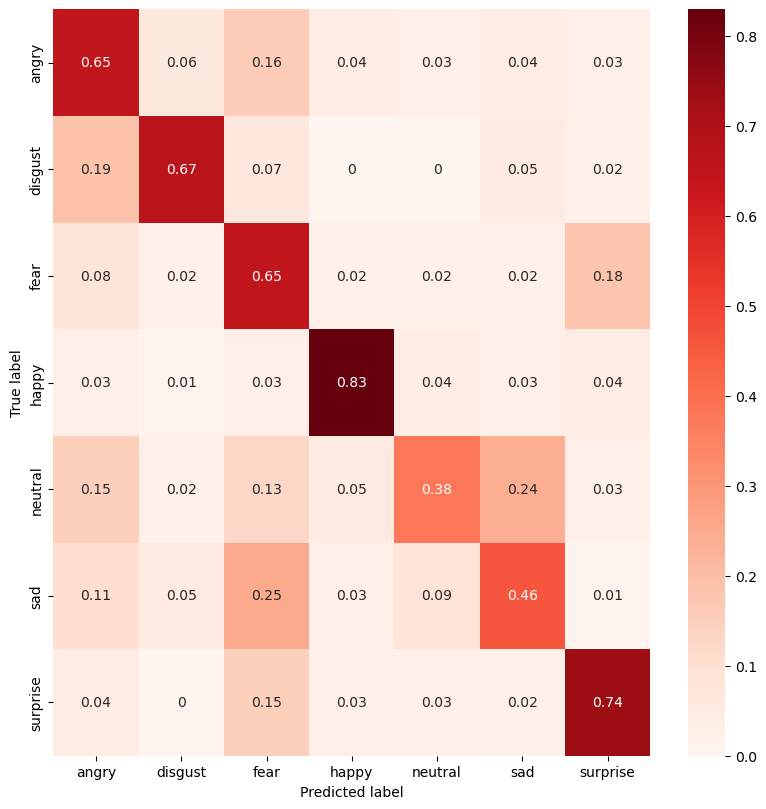

In [46]:
y_predict = model_I.predict(X_test)
y_true = y_test
res = tf.math.confusion_matrix(y_true, y_predict.argmax(axis=1)).numpy()
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
con_mat_norm = np.around(res.astype('float') / res.sum(axis=1)[:, np.newaxis], decimals = 2)
con_mat_df = pd.DataFrame(con_mat_norm, index = class_names, columns = class_names)

figure = plt.figure(figsize = (8,8))
sns.heatmap(con_mat_df, annot = True, cmap = plt.cm.Reds)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("/kaggle/working/confusion_matrix_inv3_1.png")
plt.show()

In [48]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 7)
model_I.evaluate(X_test, y_test)
print(X_test.shape)
print(y_test.shape)

221/221 [==============================] - 6s 19ms/step - loss: 1.7415 - acc: 0.5847
(7048, 75, 75, 3)
(7048, 7)
